In [1]:
import pandas as pd
import numpy as np
import pickle

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans, AffinityPropagation, AgglomerativeClustering, DBSCAN
import hdbscan
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.impute import KNNImputer
from scipy.cluster.hierarchy import dendrogram

# import pca and tsne
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from matplotlib import pyplot as plt
# do the inline thing
%matplotlib inline

import seaborn as sns


### Dataset and preprocessing

In [2]:
label_scheme = 'labels_1'

pd.options.display.max_columns = None

dataset = pd.read_csv(f'../processed_data/dataset_allfeatures_inc_labels.csv', low_memory=False)
dataset = dataset[dataset[label_scheme].notna()].reset_index(drop=True)
print(dataset[label_scheme].value_counts())

# Features and labels.
X = dataset.iloc[:,14:]
# X=X[['Amplitude_g', 'PeriodLS_g', 'StetsonK_g', ]]
X_cols = X.columns.tolist()
y_names = dataset[label_scheme]


X

labels_1
dwarf_nova_SU_UMa    572
dwarf_nova_Z_Cam     174
nova_like            144
nova_like_VY_Scl     120
dwarf_nova_U_Gem     116
polar                114
dwarf_nova_WZ_Sge     58
int_polar             49
AMCVn                 46
nova                  46
Name: count, dtype: int64


,Amplitude_g,AndersonDarling_g,Autocor_length_g,Beyond1Std_g,CAR_mean_g,CAR_sigma_g,CAR_tau_g,Con_g,Eta_e_g,FluxPercentileRatioMid20_g,FluxPercentileRatioMid35_g,FluxPercentileRatioMid50_g,FluxPercentileRatioMid65_g,FluxPercentileRatioMid80_g,Freq1_harmonics_amplitude_0_g,Freq1_harmonics_amplitude_1_g,Freq1_harmonics_amplitude_2_g,Freq1_harmonics_amplitude_3_g,Freq1_harmonics_rel_phase_1_g,Freq1_harmonics_rel_phase_2_g,Freq1_harmonics_rel_phase_3_g,Freq2_harmonics_amplitude_0_g,Freq2_harmonics_amplitude_1_g,Freq2_harmonics_amplitude_2_g,Freq2_harmonics_amplitude_3_g,Freq2_harmonics_rel_phase_1_g,Freq2_harmonics_rel_phase_2_g,Freq2_harmonics_rel_phase_3_g,Freq3_harmonics_amplitude_0_g,Freq3_harmonics_amplitude_1_g,Freq3_harmonics_amplitude_2_g,Freq3_harmonics_amplitude_3_g,Freq3_harmonics_rel_phase_1_g,Freq3_harmonics_rel_phase_2_g,Freq3_harmonics_rel_phase_3_g,Gskew_g,LinearTrend_g,MaxSlope_g,Mean_g,Meanvariance_g,MedianAbsDev_g,MedianBRP_g,PairSlopeTrend_g,PercentAmplitude_g,PercentDifferenceFluxPercentile_g,PeriodLS_g,Period_fit_g,Psi_CS_g,Psi_eta_g,Q31_g,Rcs_g,Skew_g,SlottedA_length_g,SmallKurtosis_g,Std_g,StetsonK_g,StetsonK_AC_g,StructureFunction_index_21_g,StructureFunction_index_31_g,StructureFunction_index_32_g,Amplitude_r,AndersonDarling_r,Autocor_length_r,Beyond1Std_r,CAR_mean_r,CAR_sigma_r,CAR_tau_r,Con_r,Eta_e_r,FluxPercentileRatioMid20_r,FluxPercentileRatioMid35_r,FluxPercentileRatioMid50_r,FluxPercentileRatioMid65_r,FluxPercentileRatioMid80_r,Freq1_harmonics_amplitude_0_r,Freq1_harmonics_amplitude_1_r,Freq1_harmonics_amplitude_2_r,Freq1_harmonics_amplitude_3_r,Freq1_harmonics_rel_phase_1_r,Freq1_harmonics_rel_phase_2_r,Freq1_harmonics_rel_phase_3_r,Freq2_harmonics_amplitude_0_r,Freq2_harmonics_amplitude_1_r,Freq2_harmonics_amplitude_2_r,Freq2_harmonics_amplitude_3_r,Freq2_harmonics_rel_phase_1_r,Freq2_harmonics_rel_phase_2_r,Freq2_harmonics_rel_phase_3_r,Freq3_harmonics_amplitude_0_r,Freq3_harmonics_amplitude_1_r,Freq3_harmonics_amplitude_2_r,Freq3_harmonics_amplitude_3_r,Freq3_harmonics_rel_phase_1_r,Freq3_harmonics_rel_phase_2_r,Freq3_harmonics_rel_phase_3_r,Gskew_r,LinearTrend_r,MaxSlope_r,Mean_r,Meanvariance_r,MedianAbsDev_r,MedianBRP_r,PairSlopeTrend_r,PercentAmplitude_r,PercentDifferenceFluxPercentile_r,PeriodLS_r,Period_fit_r,Psi_CS_r,Psi_eta_r,Q31_r,Rcs_r,Skew_r,SlottedA_length_r,SmallKurtosis_r,Std_r,StetsonK_r,StetsonK_AC_r,StructureFunction_index_21_r,StructureFunction_index_31_r,StructureFunction_index_32_r,Q31_color,StetsonJ,StetsonL,median_g,min_mag_g,max_mag_g,n_obs_g,dif_min_mean_g,dif_min_median_g,dif_max_mean_g,dif_max_median_g,dif_max_min_g,temporal_baseline_g,kurtosis_g,pwr_max_g,freq_pwr_max_g,FalseAlarm_prob_g,pwr_maxovermean_g,npeaks_pt5to1_g,rrate_pt5to1_g,drate_pt5to1_g,amp_pt5to1_g,npeaks_1to2_g,rrate_1to2_g,drate_1to2_g,amp_1to2_g,npeaks_2to5_g,rrate_2to5_g,drate_2to5_g,amp_2to5_g,npeaks_above5_g,rrate_above5_g,drate_above5_g,amp_above5_g,rollstd_ratio_t20s10_g,stdstilllev_t20s10_g,rollstd_ratio_t10s5_g,stdstilllev_t10s5g,pnts_leq_rollMedWin20-1mag_g,pnts_leq_rollMedWin20-2mag_g,pnts_leq_rollMedWin20-5mag_g,pnts_geq_rollMedWin20+1mag_g,pnts_geq_rollMedWin20+2mag_g,pnts_geq_rollMedWin20+3mag_g,pnts_leq_median-1mag_g,pnts_leq_median-2mag_g,pnts_leq_median-5mag_g,pnts_geq_median+1mag_g,pnts_geq_median+2mag_g,pnts_geq_median+3mag_g,median_r,min_mag_r,max_mag_r,n_obs_r,dif_min_mean_r,dif_min_median_r,dif_max_mean_r,dif_max_median_r,dif_max_min_r,temporal_baseline_r,kurtosis_r,pwr_max_r,freq_pwr_max_r,FalseAlarm_prob_r,pwr_maxovermean_r,npeaks_pt5to1_r,rrate_pt5to1_r,drate_pt5to1_r,amp_pt5to1_r,npeaks_1to2_r,rrate_1to2_r,drate_1to2_r,amp_1to2_r,npeaks_2to5_r,rrate_2to5_r,drate_2to5_r,amp_2to5_r,npeaks_above5_r,rrate_above5_r,drate_above5_r,amp_above5_r,rollstd_ratio_t20s10_r,stdstilllev_t20s10_r,rollstd_ratio_t10s5_r,stdstilllev_t10s5r,pnts_leq_rollMedWin20-1mag_r,pnts_leq_rollMedWin20-2mag_r,pnts_leq_rollMedWin20-5mag_r,pnts_geq_rollMedWin20+1mag_r,pnts_geq_rollMedWin20+2mag_r,pnts_geq_rollM

In [3]:
enc = LabelEncoder().fit(y_names)
y = enc.transform(y_names)

# Train, test, split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)

# Scale data.
scaler = StandardScaler()
X_train_proc = scaler.fit_transform(X_train)
X_test_proc = scaler.transform(X_test)
scaler2 = StandardScaler()
X_proc = scaler2.fit_transform(X)

# Impute missing values with knn imputer.
imputer = KNNImputer(n_neighbors=5)
X_train_proc = imputer.fit_transform(X_train_proc)
X_test_proc = imputer.transform(X_test_proc)
imputer2 = KNNImputer(n_neighbors=5)
X_proc = imputer2.fit_transform(X_proc)

# # MinMaxScaler
# scaler3 = MinMaxScaler()
# X_train_proc = scaler3.fit_transform(X_train_proc)
# X_test_proc = scaler3.transform(X_test_proc)
# scaler4 = MinMaxScaler()
# X_proc = scaler4.fit_transform(X_proc)


### K Means tuning

Text(0, 0.5, 'Silhouette')

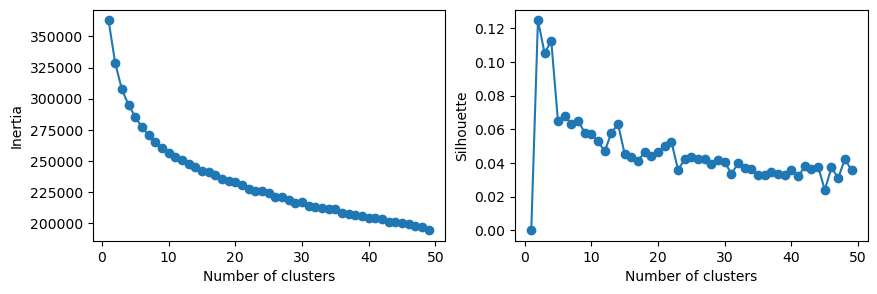

In [4]:
# fitting multiple k-means algorithms and storing the values in an empty list
clustermax = 50
inertia = []
silhouette = []

for cluster in range(1,clustermax):
    kmeans = KMeans(n_clusters=cluster, 
                    init='k-means++',
                    n_init=10,
                    verbose=0,
                    random_state=1)
    kmeans.fit(X_proc)
    inertia.append(kmeans.inertia_)
    if cluster > 1:
        silhouette.append(silhouette_score(X_proc, kmeans.labels_))
    else:
        silhouette.append(0)


# converting the results into a dataframe and plotting them
fig, ax = plt.subplots(1,2, figsize=(10,3))
frame = pd.DataFrame({'Cluster':range(1,clustermax), 'inertia':inertia})

ax[0].plot(frame['Cluster'], frame['inertia'], marker='o')
ax[0].set_xlabel('Number of clusters')
ax[0].set_ylabel('Inertia')

frame = pd.DataFrame({'Cluster':range(1,clustermax), 'Silhouette':silhouette})
ax[1].plot(frame['Cluster'], frame['Silhouette'], marker='o')
ax[1].set_xlabel('Number of clusters')
ax[1].set_ylabel('Silhouette')


In [5]:
# Choose optimal hyperparameters, construct model and visualise clusters using PCA, t-SNE and UMAP.
kmeans = KMeans(n_clusters=10,
                init='k-means++',
                n_init=10,
                verbose=0,
                random_state=1)

kmeans.fit(X_proc)
y_pred_kmeans = kmeans.predict(X_proc)
# prepend 'label' to each element in y_pred_kmeans
y_pred_kmeans = [f'label_{x}' for x in y_pred_kmeans]

# Visualise clusters using PCA and t_SNE in 2D.
pca_kmeans = PCA(n_components=2)
X_pca_kmeans = pca_kmeans.fit_transform(X_proc)
pca_exp_var_kmeans = pca_kmeans.explained_variance_ratio_

tsne_kmeans = TSNE(n_components=2, verbose=0, perplexity=20, n_iter=500, random_state=1)
X_tsne_kmeans = tsne_kmeans.fit_transform(X_proc)

# Append this information to a dataframe.
kmeans_df = pd.DataFrame(X_proc, columns=X_cols)
kmeans_df['Cluster'] = y_pred_kmeans
kmeans_df['True_label'] = y_names
kmeans_df['PCA1'] = X_pca_kmeans[:,0]
kmeans_df['PCA2'] = X_pca_kmeans[:,1]
kmeans_df['tSNE1'] = X_tsne_kmeans[:,0]
kmeans_df['tSNE2'] = X_tsne_kmeans[:,1]

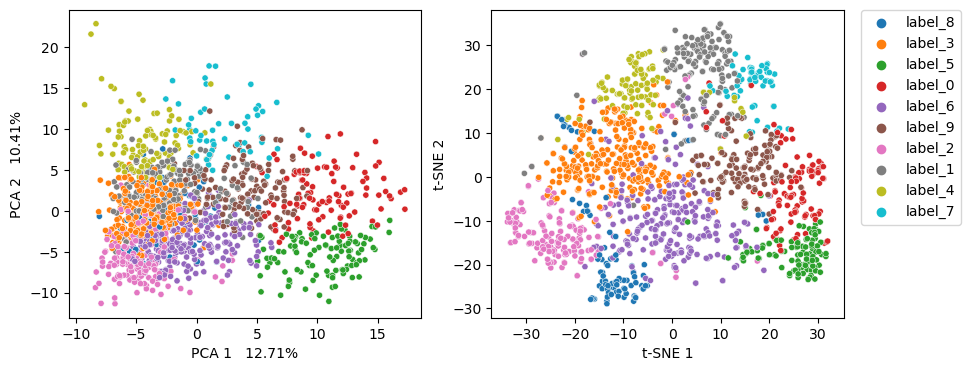

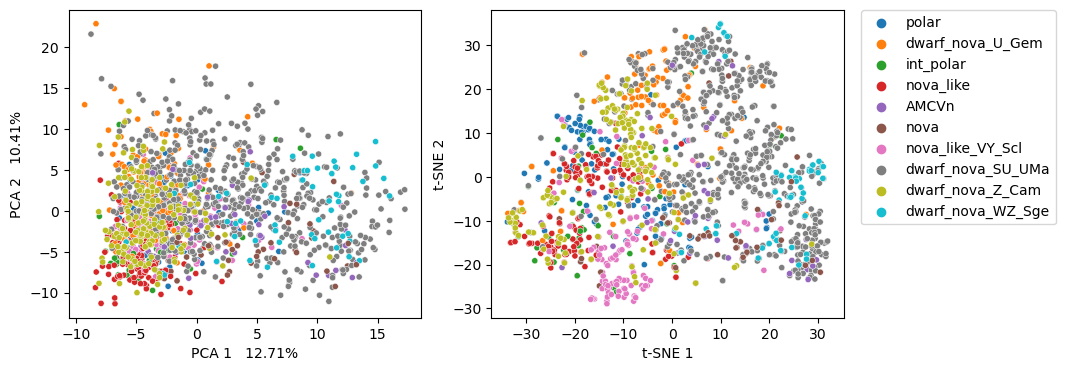

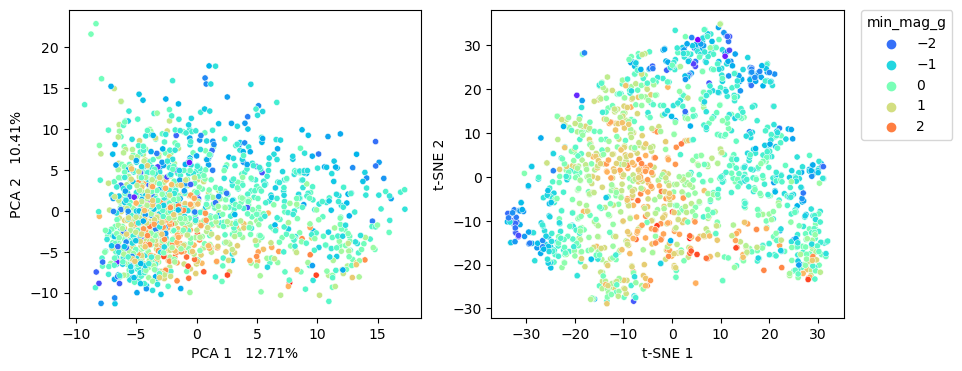

In [6]:

def cluster_plots(df, cluster, true_label, feature, pca_exp_var):
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    sns.scatterplot(x=df['PCA1'], y=df['PCA2'], hue=df[cluster], ax=ax[0], s=20)
    sns.scatterplot(x=df['tSNE1'], y=df['tSNE2'], hue=df[cluster], ax=ax[1], s=20)
    ax[0].set_xlabel(f'PCA 1   {pca_exp_var[0]*100:.2f}%')
    ax[0].set_ylabel(f'PCA 2   {pca_exp_var[1]*100:.2f}%')
    ax[1].set_xlabel(f't-SNE 1')
    ax[1].set_ylabel(f't-SNE 2')
    # Show the legend for the right hand subplot only and place outside the plot.
    ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    # Turn off the legend for the left hand subplot as it is identical to the right hand one.
    ax[0].legend().set_visible(False)
    plt.show()

    fig2, ax2 = plt.subplots(1,2, figsize=(10,4))
    sns.scatterplot(x=df['PCA1'], y=df['PCA2'], hue=df[true_label], ax=ax2[0], s=20)
    sns.scatterplot(x=df['tSNE1'], y=df['tSNE2'], hue=df[true_label], ax=ax2[1], s=20)
    ax2[0].set_xlabel(f'PCA 1   {pca_exp_var[0]*100:.2f}%')
    ax2[0].set_ylabel(f'PCA 2   {pca_exp_var[1]*100:.2f}%')
    ax2[1].set_xlabel(f't-SNE 1')
    ax2[1].set_ylabel(f't-SNE 2')
    # Show the legend for the right hand subplot only and place outside the plot.
    ax2[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    # Turn off the legend for the left hand subplot as it is identical to the right hand one.
    ax2[0].legend().set_visible(False)
    plt.show()

    fig3, ax3 = plt.subplots(1,2, figsize=(10,4))
    sns.scatterplot(x=df['PCA1'], y=df['PCA2'], hue=df[feature], palette='rainbow', ax=ax3[0], s=20)
    sns.scatterplot(x=df['tSNE1'], y=df['tSNE2'], hue=df[feature], palette='rainbow', ax=ax3[1], s=20)
    ax3[0].set_xlabel(f'PCA 1   {pca_exp_var[0]*100:.2f}%')
    ax3[0].set_ylabel(f'PCA 2   {pca_exp_var[1]*100:.2f}%')
    ax3[1].set_xlabel(f't-SNE 1')
    ax3[1].set_ylabel(f't-SNE 2')
    # Show the legend for the right hand subplot only and place outside the plot.
    ax3[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.).set_title(feature)
    # Turn off the legend for the left hand subplot as it is identical to the right hand one.
    ax3[0].legend().set_visible(False)
    # legend title
    
    plt.show()

cluster_plots(kmeans_df, 'Cluster', 'True_label', 'min_mag_g', pca_exp_var_kmeans)

### Affinity propagation tuning

/Users/aridmist/opt/anaconda3/envs/mainenv/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:142: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


Number of clusters: [132, 132, 133, 131, 132, 132, 133, 135, 135, 37]


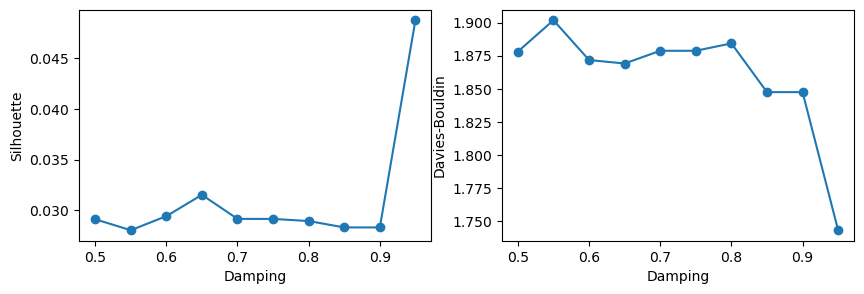

In [7]:
# Affinity propagation

damping = np.arange(0.5,1,0.05)

# inertia = []
silhouette = []
davies_bouldin = []
n_clusters = []

for d in damping:
    ap = AffinityPropagation(damping=d,
                            max_iter=200,
                            convergence_iter=15,
                            copy=True,
                            preference=None,
                            affinity='euclidean',
                            verbose=False).fit(X_proc)
    n_clusters.append(len(ap.cluster_centers_indices_))
    if cluster > 1:
        silhouette.append(silhouette_score(X_proc, ap.labels_))
    else:
        silhouette.append(0)
    davies_bouldin.append(davies_bouldin_score(X_proc, ap.labels_))

fig, ax = plt.subplots(1,2, figsize=(10,3))
frame = pd.DataFrame({'Damping':damping, 'Silhouette':silhouette})
frame2 = pd.DataFrame({'Damping':damping, 'Davies-Bouldin':davies_bouldin})
ax[0].plot(frame['Damping'], frame['Silhouette'], marker='o')
ax[0].set_xlabel('Damping')
ax[0].set_ylabel('Silhouette')
ax[1].plot(frame2['Damping'], frame2['Davies-Bouldin'], marker='o')
ax[1].set_xlabel('Damping')
ax[1].set_ylabel('Davies-Bouldin')

print(f'Number of clusters: {n_clusters}')



Number of clusters: 37


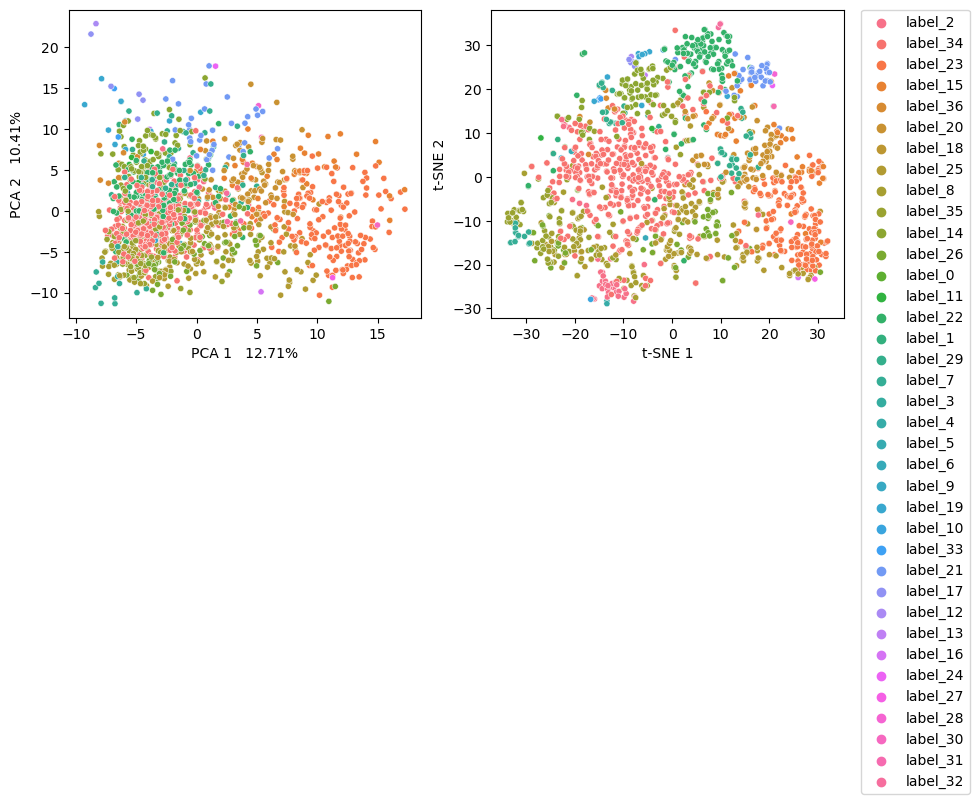

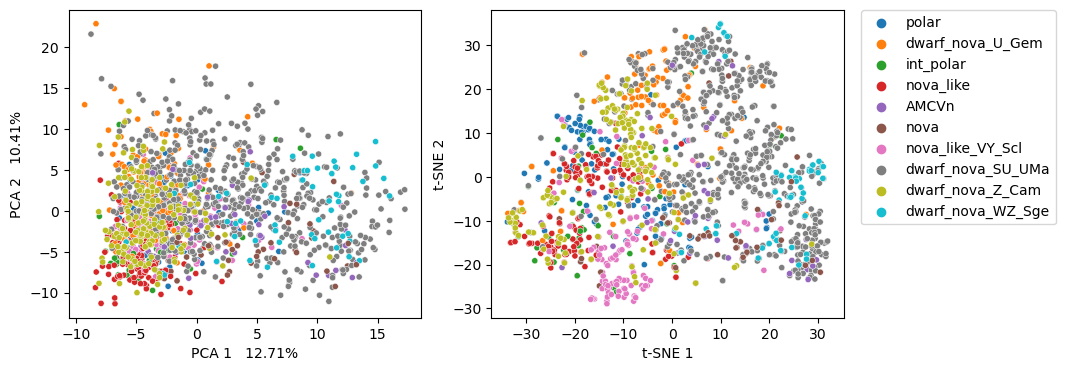

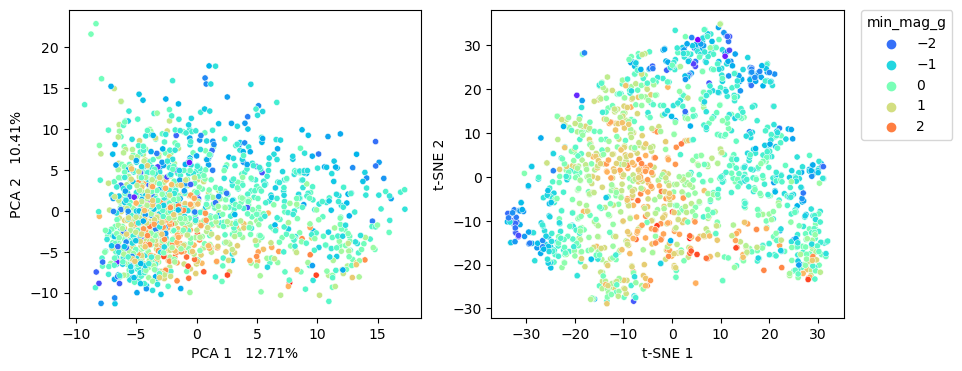

In [8]:
# Choose optimal hyperparameters, construct model and visualise clusters using PCA, t-SNE and UMAP.
ap = AffinityPropagation(damping=0.95,
                            max_iter=200,
                            convergence_iter=15,
                            copy=True,
                            preference=None,
                            affinity='euclidean',
                            verbose=False)
ap.fit(X_proc)
y_pred_ap = ap.predict(X_proc)
# prepend 'label' to each element in y_pred_ap
y_pred_ap = [f'label_{x}' for x in y_pred_ap]

print(f'Number of clusters: {len(ap.cluster_centers_indices_)}')

# Visualise clusters using PCA and t_SNE in 2D.
pca_ap = PCA(n_components=2)
X_pca_ap = pca_ap.fit_transform(X_proc)
pca_exp_var_ap = pca_ap.explained_variance_ratio_

tsne = TSNE(n_components=2, verbose=0, perplexity=20, n_iter=500, random_state=1)
X_tsne = tsne.fit_transform(X_proc)

# Append this information to a dataframe.
ap_df = pd.DataFrame(X_proc, columns=X_cols)
ap_df['Cluster'] = y_pred_ap
ap_df['True_label'] = y_names
ap_df['PCA1'] = X_pca_kmeans[:,0]
ap_df['PCA2'] = X_pca_kmeans[:,1]
ap_df['tSNE1'] = X_tsne_kmeans[:,0]
ap_df['tSNE2'] = X_tsne_kmeans[:,1]

cluster_plots(ap_df, 'Cluster', 'True_label', 'min_mag_g', pca_exp_var_ap)

# # 2D
# fig, ax = plt.subplots(1,2, figsize=(10,3))
# ax[0].scatter(X_pca[:,0], X_pca[:,1], c=y_pred, cmap='rainbow', s=10)
# ax[0].set_xlabel(f'PCA 1   {pca_exp_var[0]*100:.2f}%')
# ax[0].set_ylabel(f'PCA 2   {pca_exp_var[1]*100:.2f}%')
# ax[1].scatter(X_tsne[:,0], X_tsne[:,1], c=y_pred, cmap='rainbow', s=10)
# ax[1].set_xlabel(f't-SNE 1')
# ax[1].set_ylabel(f't-SNE 2')


### Agglomerative clustering tuning

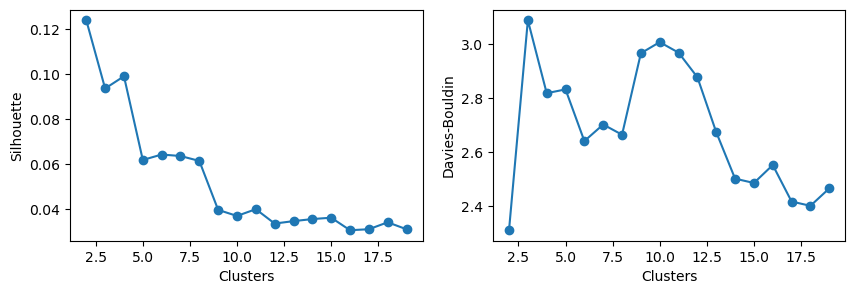

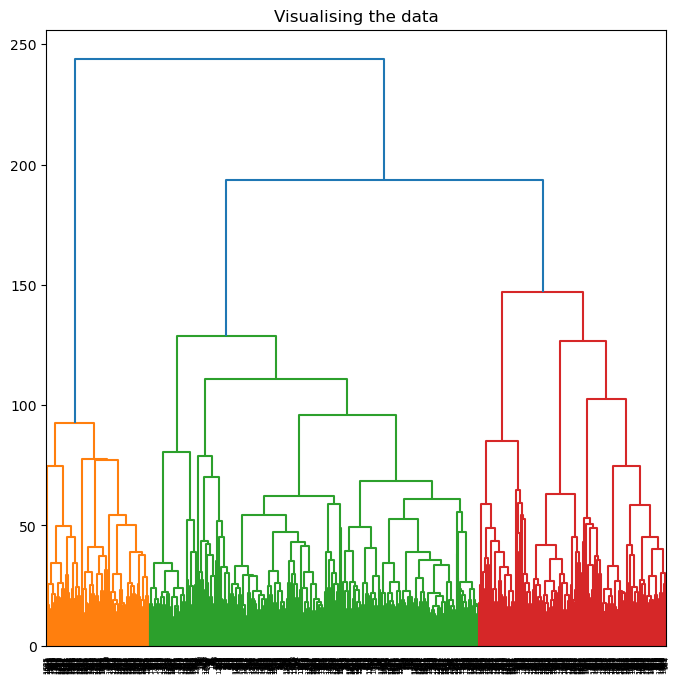

In [9]:
# Agglomerative clustering

n_clusters = np.arange(2,20,1)
linkage = ['ward']#, 'complete', 'average', 'single']
davies_bouldin = []
silhouette = []

for l in linkage:
    for cluster in n_clusters:
        ac = AgglomerativeClustering(n_clusters=cluster,
                                    metric='euclidean',
                                    memory=None,
                                    connectivity=None,
                                    compute_full_tree='auto',
                                    linkage=l,
                                    distance_threshold=None).fit(X_proc)
        
        cluster = ac.n_clusters_
        if cluster > 1:
            silhouette.append(silhouette_score(X_proc, ac.labels_))
        else:
            silhouette.append(0)
        davies_bouldin.append(davies_bouldin_score(X_proc, ac.labels_))

# plt.figure(figsize=(5,3))
# frame = pd.DataFrame({'Clusters':n_clusters, 'Silhouette':silhouette})
# plt.plot(frame['Clusters'], frame['Silhouette'], marker='o')
# plt.xlabel('Number of clusters')
# plt.ylabel('Silhouette')

fig, ax = plt.subplots(1,2, figsize=(10,3))
frame = pd.DataFrame({'Clusters':n_clusters, 'Silhouette':silhouette})
frame2 = pd.DataFrame({'Clusters':n_clusters, 'Davies-Bouldin':davies_bouldin})
ax[0].plot(frame['Clusters'], frame['Silhouette'], marker='o')
ax[0].set_xlabel('Clusters')
ax[0].set_ylabel('Silhouette')
ax[1].plot(frame2['Clusters'], frame2['Davies-Bouldin'], marker='o')
ax[1].set_xlabel('Clusters')
ax[1].set_ylabel('Davies-Bouldin')


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

import scipy.cluster.hierarchy as shc
plt.figure(figsize =(8, 8))
plt.title('Visualising the data')
Dendrogram = shc.dendrogram((shc.linkage(X_proc, method ='ward')))

Text(0, 0.5, 't-SNE 2')

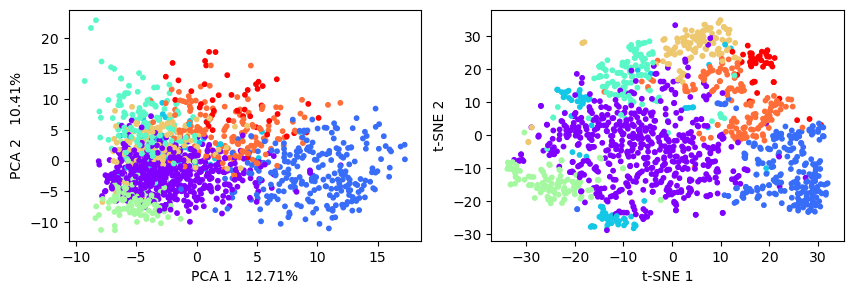

In [10]:
# Choose optimal hyperparameters, construct model and visualise clusters using PCA, t-SNE and UMAP.
ac = AgglomerativeClustering(n_clusters=8,
                            metric='euclidean',
                            memory=None,
                            connectivity=None,
                            compute_full_tree='auto',
                            linkage=l,
                            distance_threshold=None)
y_pred = ac.fit_predict(X_proc)

# print(f'Number of clusters: {len(ac.cluster_centers_indices_)}')

# Visualise clusters using PCA and t_SNE in 2D.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_proc)
pca_exp_var = pca.explained_variance_ratio_

tsne = TSNE(n_components=2, verbose=0, perplexity=20, n_iter=500, random_state=1)
X_tsne = tsne.fit_transform(X_proc)

# 2D
fig, ax = plt.subplots(1,2, figsize=(10,3))
ax[0].scatter(X_pca[:,0], X_pca[:,1], c=y_pred, cmap='rainbow', s=10)
ax[0].set_xlabel(f'PCA 1   {pca_exp_var[0]*100:.2f}%')
ax[0].set_ylabel(f'PCA 2   {pca_exp_var[1]*100:.2f}%')
ax[1].scatter(X_tsne[:,0], X_tsne[:,1], c=y_pred, cmap='rainbow', s=10)
ax[1].set_xlabel(f't-SNE 1')
ax[1].set_ylabel(f't-SNE 2')

# add a legend to the plots


### DBSCAN

min_samples 2
eps: 1, min_samples: 2, clusters: 1
eps: 2, min_samples: 2, clusters: 1
eps: 3, min_samples: 2, clusters: 1
eps: 4, min_samples: 2, clusters: 1
eps: 5, min_samples: 2, clusters: 1
eps: 6, min_samples: 2, clusters: 1
eps: 7, min_samples: 2, clusters: 3
eps: 8, min_samples: 2, clusters: 3
eps: 9, min_samples: 2, clusters: 26
eps: 10, min_samples: 2, clusters: 48
eps: 11, min_samples: 2, clusters: 35
eps: 12, min_samples: 2, clusters: 20
eps: 13, min_samples: 2, clusters: 14
eps: 14, min_samples: 2, clusters: 8
eps: 15, min_samples: 2, clusters: 4
eps: 16, min_samples: 2, clusters: 4
eps: 17, min_samples: 2, clusters: 4
eps: 18, min_samples: 2, clusters: 4
eps: 19, min_samples: 2, clusters: 3
20
eps: 20, min_samples: 2, clusters: 4
eps: 21, min_samples: 2, clusters: 4
eps: 22, min_samples: 2, clusters: 4
eps: 23, min_samples: 2, clusters: 4
eps: 24, min_samples: 2, clusters: 2
eps: 25, min_samples: 2, clusters: 2
eps: 26, min_samples: 2, clusters: 2
eps: 27, min_samples: 2, 

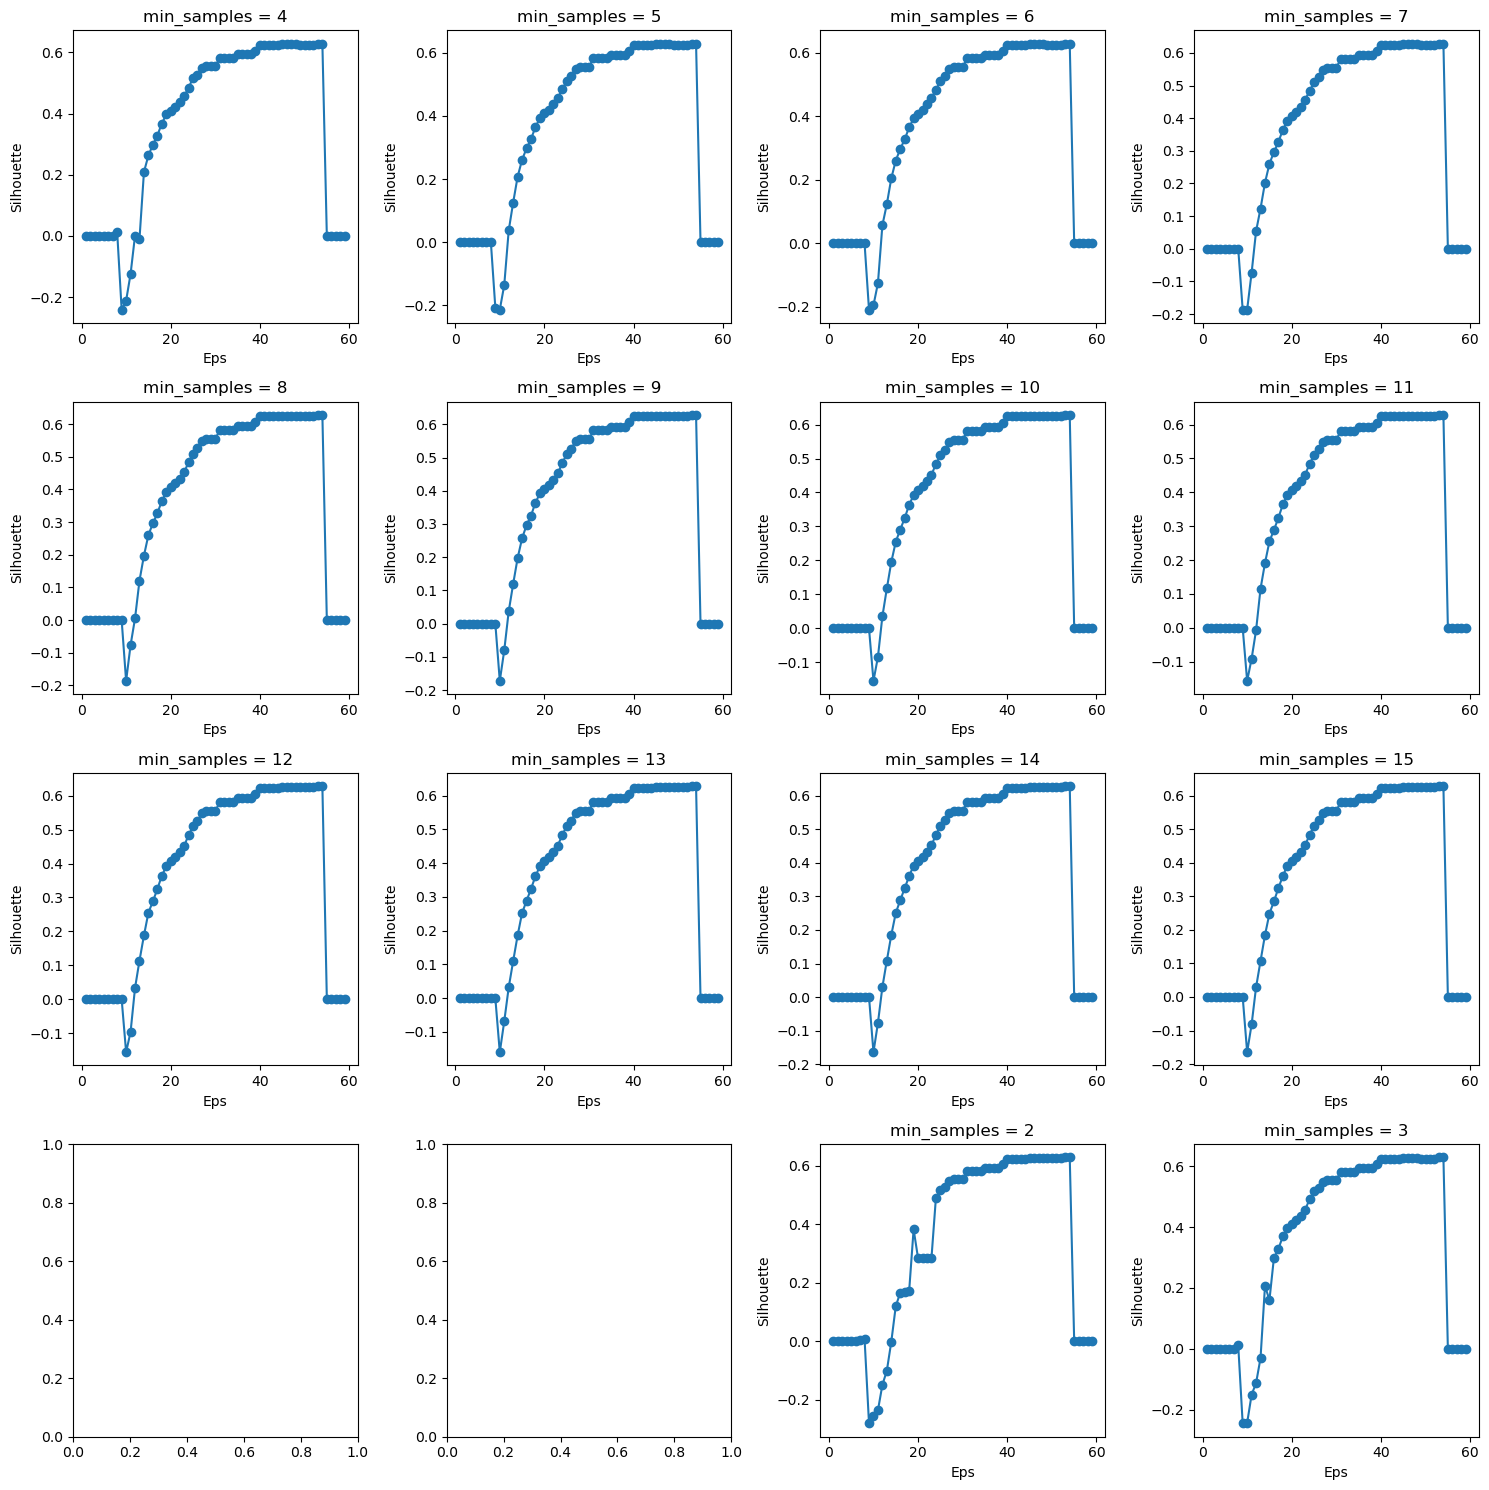

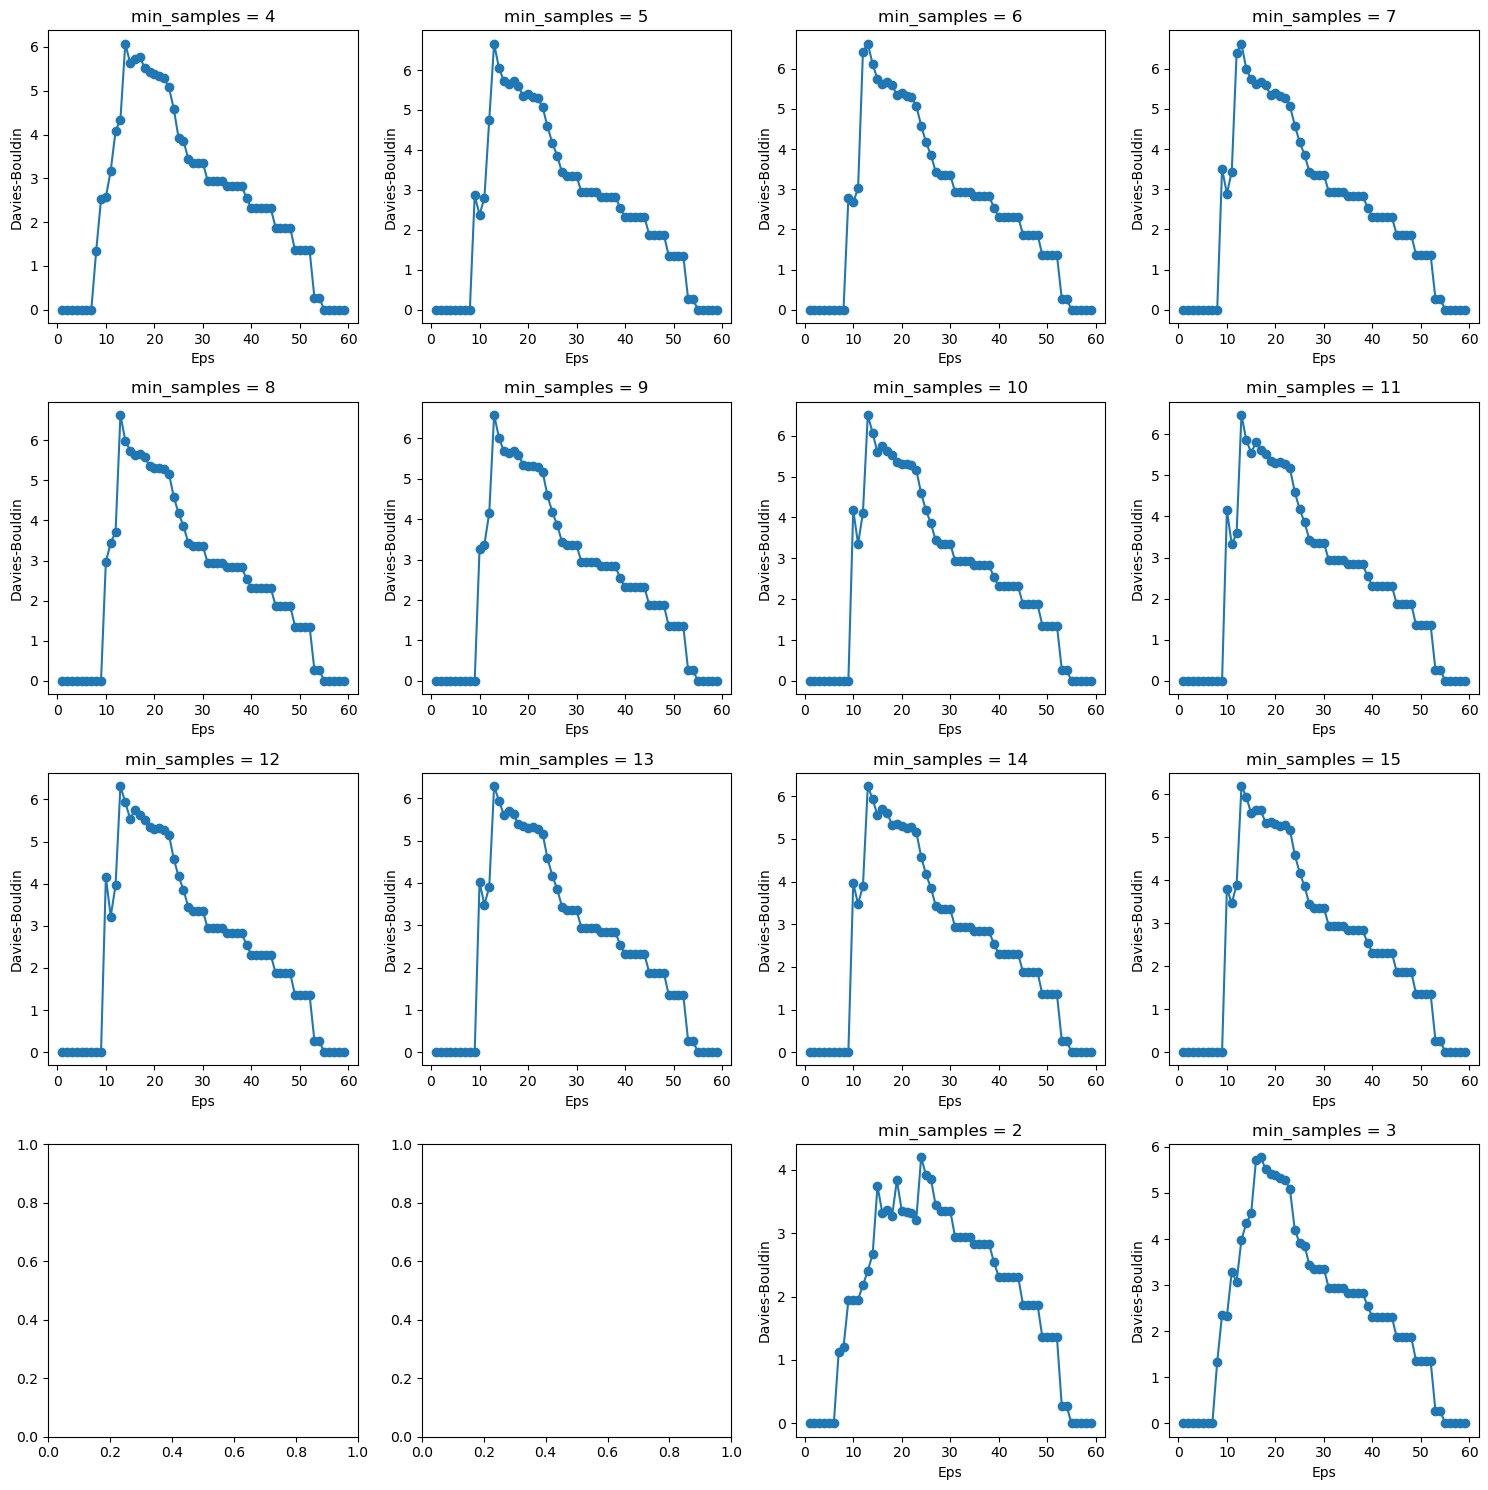

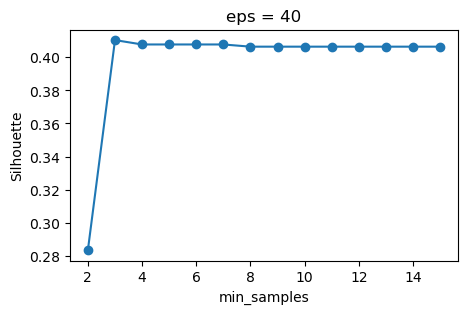

In [11]:
# DBSCAN

eps = np.arange(1,60,1)
min_samples = np.arange(2,16,1)
sil_n_samples = []

# Subplot for each min_samples
rows = 4
cols = 4
fig, ax = plt.subplots(rows,cols, figsize=(15,15))
fig2, ax2 = plt.subplots(rows,cols, figsize=(15,15))

for m in min_samples:
    print('min_samples',m)
    silhouette = []
    davies_bouldin = []

    for e in eps:
        db = DBSCAN(eps=e,
                    min_samples=m,
                    metric='euclidean',
                    metric_params=None,
                    algorithm='auto',
                    leaf_size=30,
                    p=None,
                    n_jobs=None).fit(X_proc)
        # for a given value of eps store the silhouette score for each min_samples
        if e == 20:
            print(e)
            sil_n_samples.append(silhouette_score(X_proc, db.labels_))
        
        print(f'eps: {e}, min_samples: {m}, clusters: {len(np.unique(db.labels_))}')
        if len(np.unique(db.labels_)) > 1:
            silhouette.append(silhouette_score(X_proc, db.labels_))
        else:
            silhouette.append(0)
        
        if len(np.unique(db.labels_)) > 1:
            davies_bouldin.append(davies_bouldin_score(X_proc, db.labels_))
        else:
            davies_bouldin.append(0)
    
    frame = pd.DataFrame({'Eps':eps, 'Silhouette':silhouette})
    # Append to the subplot taking into account the row and column
    # Generalise this to any number of rows and columns
    
    ax[(m-rows)//cols, (m-rows)%cols].plot(frame['Eps'], frame['Silhouette'], marker='o')
    ax[(m-rows)//cols, (m-rows)%cols].set_xlabel('Eps')
    ax[(m-rows)//cols, (m-rows)%cols].set_ylabel('Silhouette')
    ax[(m-rows)//cols, (m-rows)%cols].set_title(f'min_samples = {m}')

    # Perform the same for the Davies-Bouldin score
    frame2 = pd.DataFrame({'Eps':eps, 'Davies-Bouldin':davies_bouldin})
    ax2[(m-rows)//cols, (m-rows)%cols].plot(frame2['Eps'], frame2['Davies-Bouldin'], marker='o')
    ax2[(m-rows)//cols, (m-rows)%cols].set_xlabel('Eps')
    ax2[(m-rows)//cols, (m-rows)%cols].set_ylabel('Davies-Bouldin')
    ax2[(m-rows)//cols, (m-rows)%cols].set_title(f'min_samples = {m}')

fig3 = plt.figure(figsize=(5,3))
plt.plot(min_samples, sil_n_samples, marker='o')
plt.xlabel('min_samples')
plt.ylabel('Silhouette')
plt.title(f'eps = 40')

# Plot fig
fig.tight_layout()
fig2.tight_layout()







Number of clusters: 2


Text(0, 0.5, 't-SNE 2')

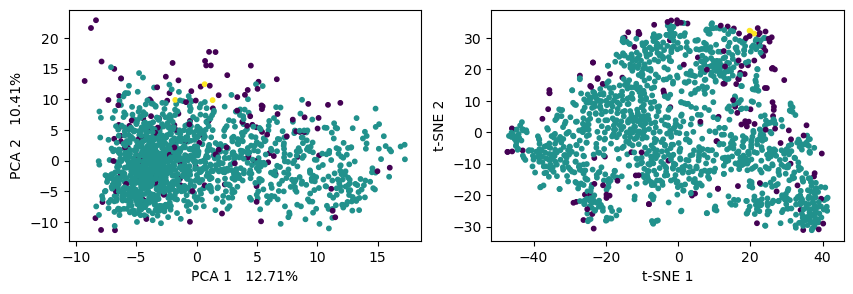

In [36]:
# Choose optimal hyperparameters, construct model and visualise clusters using PCA, t-SNE and UMAP.
db = DBSCAN(eps=15,
            min_samples=3,
            metric='euclidean',
            metric_params=None,
            algorithm='auto',
            leaf_size=30,
            p=None,
            n_jobs=None)

y_pred = db.fit_predict(X_proc)

print(f'Number of clusters: {db.labels_.max()+1}')

# Visualise clusters using PCA and t_SNE in 2D.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_proc)
pca_exp_var = pca.explained_variance_ratio_

tsne = TSNE(n_components=2, verbose=0, perplexity=30, n_iter=1000, random_state=1)
X_tsne = tsne.fit_transform(X_proc)

# 2D
fig, ax = plt.subplots(1,2, figsize=(10,3))
ax[0].scatter(X_pca[:,0], X_pca[:,1], c=y_pred, s=10)
ax[0].set_xlabel(f'PCA 1   {pca_exp_var[0]*100:.2f}%')
ax[0].set_ylabel(f'PCA 2   {pca_exp_var[1]*100:.2f}%')
ax[1].scatter(X_tsne[:,0], X_tsne[:,1], c=y_pred, s=10)
ax[1].set_xlabel(f't-SNE 1')
ax[1].set_ylabel(f't-SNE 2')

### HDBSCAN

Number of clusters: 2


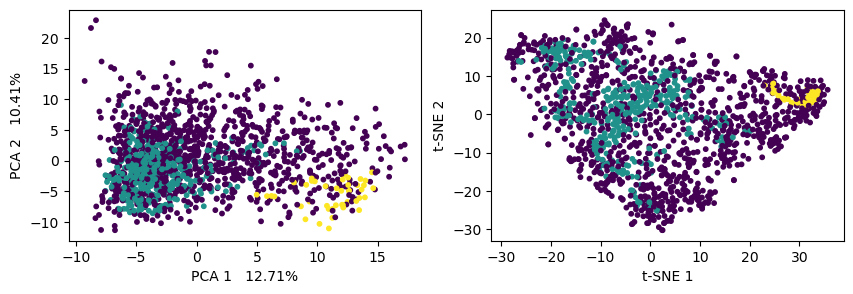

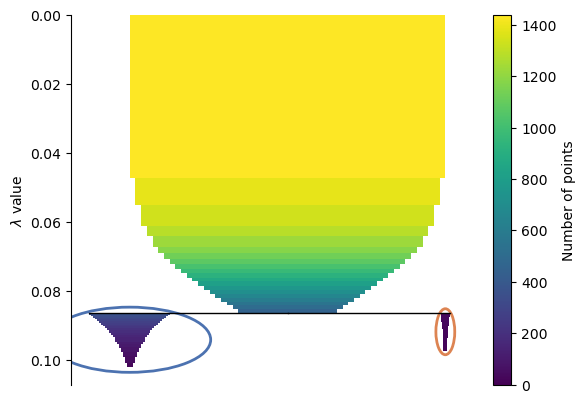

<Axes: ylabel='distance'>

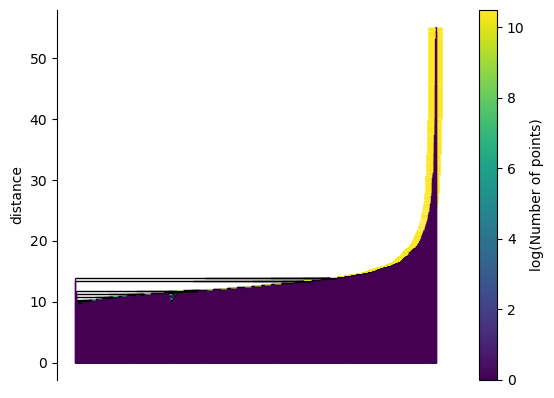

In [39]:
# HDBSCAN
min_cluster_size = 15
min_samples = 5

hdb = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
            min_samples=min_samples,
            cluster_selection_epsilon=0.0,
            ).fit(X_proc)

y_pred = hdb.fit_predict(X_proc)

print(f'Number of clusters: {hdb.labels_.max()+1}')

# Visualise clusters using PCA and t_SNE in 2D.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_proc)
pca_exp_var = pca.explained_variance_ratio_

tsne = TSNE(n_components=2, verbose=0, perplexity=50, n_iter=1000, random_state=1)
X_tsne = tsne.fit_transform(X_proc)

# 2D
fig, ax = plt.subplots(1,2, figsize=(10,3))
ax[0].scatter(X_pca[:,0], X_pca[:,1], c=y_pred, s=10)
ax[0].set_xlabel(f'PCA 1   {pca_exp_var[0]*100:.2f}%')
ax[0].set_ylabel(f'PCA 2   {pca_exp_var[1]*100:.2f}%')
ax[1].scatter(X_tsne[:,0], X_tsne[:,1], c=y_pred, s=10)
ax[1].set_xlabel(f't-SNE 1')
ax[1].set_ylabel(f't-SNE 2')
plt.show()

hdb.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette('deep', 8))
plt.show()

hdb.single_linkage_tree_.plot()
